In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.datasets import make_blobs
import time
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
%load_ext cython

In [3]:
class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', epsilon=10 ** (-5), max_iter=1000, 
                 random_state=None, init='random'):

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.init = init
    
    def fit_run(self):
        for _ in range(self.max_iter):
            finish = True
            broad = self.centroids.reshape(self.k, 1, self.X.shape[1])
            self.labels = ((self.d - broad) ** 2).sum(axis=2).argmin(axis=0)
            for i in range(self.k):
                new_center = self.X[self.labels == i].mean(axis=0)
                if np.abs(new_center - self.centroids[i]).max() > self.epsilon:
                    finish = False
                self.centroids[i] = new_center
            if finish:
                return self
        
    
    def fit(self, X, y=None):

        np.random.seed(self.random_state)
        
        self.labels = np.empty(X.shape[0])
        
        self.centroids = np.empty((self.k, X.shape[1]))
        
        self.X = X
        self.d = np.empty((self.k, self.X.shape[0], self.X.shape[1]))
        for i in range(self.k):
            self.d[i] = self.X.copy()
        self.distances_to_centers = np.empty((self.X.shape[0], self.k))
        if self.init == 'random':
            t0 = time.clock()
            for i, value in enumerate(np.random.choice(range(0, X.shape[0]), self.k, replace=False)):
                self.centroids[i] = X[value]
            t1 = time.clock()
        elif self.init == 'k-means':
            batch = X[np.random.randint(0, X.shape[0], 50 * self.k)]
            self.centroids[0] = batch[0]
            prob = np.empty(batch.shape[0])
            batch_to_centers = np.empty((batch.shape[0], 1))
            t0 = time.clock()
            for i in range(1, self.k):
                for j in range(i):
                    batch_to_centers[:, j] = ((batch - self.centroids[j]) ** 2).sum(axis=1)
                prob = batch_to_centers.min(axis=1)
                batch_to_centers = np.empty((batch.shape[0], i + 1))
                self.centroids[i] = batch[np.random.choice(range(batch.shape[0]), p=(prob / prob.sum()))]
            t1 = time.clock()
        else:
            raise Exception('{} is not a valid init method'.format(self.init))
        self.fit_run()
        return t1 - t0


    def predict(self, X):

        self.fit(X)
        return self.labels
    

В реализации на питоне все большие вычисления переведены в матричную форму, циклы в основном методе fit_run остались только 
в 2-ух местах: главный цикл и для переноса центроид. Если бы в numpy был встроенный groupby как в pandas, можно было бы и перенос центроид векторизовать, но вручную векторизовать группировку по labels не удалось. Также для ускорения была пожертвована память -- вместо циклов добавились размерности, что сильно ускорило алгоритм.

In [77]:
%%cython -a
import numpy as np
cimport numpy as cnp
cimport cython


cdef class KmeansCython: 
    
    cdef int k, random_state, max_iter;
    cdef str metric, init;
    cdef cnp.float64_t epsilon;
    
    def __init__(self,
                 int k_=2, 
                 str metric_='euclidean', 
                 cnp.float64_t epsilon_=10 ** (-5),
                 int max_iter_=1000, 
                 int random_state_=1234,
                 str init_='random'):

        self.k = k_
        self.random_state = random_state_
        self.metric = metric_
        self.epsilon = epsilon_
        self.max_iter = max_iter_
        self.init = init_
    
    @cython.boundscheck(False)
    @cython.cdivision(True)   
    @cython.wraparound(False)
    def fit_run(self,
                cnp.ndarray[cnp.float64_t, ndim=2] X,
                cnp.ndarray[cnp.float64_t, ndim=2] centroids):
        
        cdef cnp.ndarray[cnp.float64_t, ndim=1] labels = np.zeros(X.shape[0]);
        cdef cnp.ndarray[cnp.float64_t, ndim=1] new_center = np.zeros(X.shape[1]); 
        cdef int finish, curr_min, X_shape0, X_shape1, i, j, t, count;
        cdef cnp.float64_t curr_min_dist, dist, diff, curr_max;
        
        X_shape0 = X.shape[0]
        X_shape1 = X.shape[1]
        
        for _ in range(self.max_iter):
            finish = True
            
            for i in range(X_shape0):
                curr_min = 0
                curr_min_dist = -1
                for j in range(self.k):
                    dist = 0
                    for t in range(X_shape1):
                        diff = X[i, t] - centroids[j, t]
                        dist += diff * diff
                    if curr_min_dist == -1 or dist < curr_min_dist:
                        curr_min_dist = dist
                        curr_min = j
                labels[i] = curr_min 
            
            for i in range(self.k):
                count = 0
                for j in range(X_shape1):
                    new_center[j] = 0
                for j in range(X_shape0):
                    if labels[j] == i:
                        for t in range(X_shape1):
                            new_center[t] += X[j, t]
                        count += 1
                for t in range(X_shape1):
                    new_center[t] /= count
                curr_max = 0
                for t in range(X_shape1):
                    diff = new_center[t] - centroids[i, t]
                    if diff < 0:
                        diff = - diff
                    if diff > curr_max:
                        curr_max = diff
                if curr_max > self.epsilon:
                    finish = False
                for t in range(X_shape1):
                    centroids[i, t] = new_center[t]
            if finish:
                return labels
        
    @cython.boundscheck(False)
    @cython.cdivision(True)   
    @cython.wraparound(False)
    def fit(self, cnp.ndarray[cnp.float64_t, ndim=2] X):
        
        cdef cnp.ndarray[cnp.float64_t, ndim=1] labels;
        cdef cnp.ndarray[cnp.float64_t, ndim=2] centroids = np.empty((self.k, X.shape[1]));
        cdef int i, value;
        
        np.random.seed(self.random_state)
        
        if self.init == 'random':
            for i, value in enumerate(np.random.choice(range(0, X.shape[0]), self.k, replace=False)):
                for j in range(X.shape[1]):
                    centroids[i, j] = X[value, j]
        else:
            raise Exception('{} is not a valid init method'.format(self.init))
        return self.fit_run(X, centroids)
    
    def predict(self, cnp.ndarray[cnp.float64_t, ndim=2] X):
        return self.fit(X)
    

In [78]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython


cdef class KmeansCythonNumpy: 
    
    cdef int k, random_state, max_iter;
    cdef str metric, init;
    cdef np.float64_t epsilon;
    
    def __init__(self,
                 int k_=2, 
                 str metric_='euclidean', 
                 np.float64_t epsilon_=10 ** (-5),
                 int max_iter_=1000, 
                 int random_state_=1234,
                 str init_='random'):

        self.k = k_
        self.random_state = random_state_
        self.metric = metric_
        self.epsilon = epsilon_
        self.max_iter = max_iter_
        self.init = init_
    
    @cython.boundscheck(False)
    @cython.cdivision(True)   
    @cython.wraparound(False)
    def fit_run(self,
                np.ndarray[np.float64_t, ndim=2] X,
                np.ndarray[np.float64_t, ndim=2] centroids):
        
        cdef np.ndarray[np.float64_t, ndim=1] labels = np.empty(X.shape[0]);
        cdef np.ndarray[np.float64_t, ndim=1] new_center = np.empty(X.shape[1]); 
        cdef int finish, curr_min, X_shape0, X_shape1, i, j, t, count;
        cdef np.float64_t curr_min_dist, dist, diff;
        
        X_shape0 = X.shape[0]
        X_shape1 = X.shape[1]
        
        for _ in range(self.max_iter):
            finish = True
            
            for i in range(X_shape0):
                curr_min = 0
                curr_min_dist = -1
                for j in range(self.k):
                    dist = 0
                    for t in range(X_shape1):
                        diff = X[i, t] - centroids[j, t]
                        dist += diff * diff
                    if curr_min_dist == -1 or dist < curr_min_dist:
                        curr_min_dist = dist
                        curr_min = j
                labels[i] = curr_min 
            
            for i in range(self.k):
                count = 0
                for j in range(X_shape1):
                    new_center[j] = 0
                for j in range(X_shape0):
                    if labels[j] == i:
                        for t in range(X_shape1):
                            new_center[t] += X[j, t]
                        count += 1
                for t in range(X_shape1):
                    new_center[t] /= count
                if np.abs(new_center - centroids[i]).max() > self.epsilon:
                    finish = False
                centroids[i] = new_center
            if finish:
                return labels
        
    
    @cython.boundscheck(False)
    @cython.cdivision(True)   
    @cython.wraparound(False)
    def fit(self, np.ndarray[np.float64_t, ndim=2] X):
        
        cdef np.ndarray[np.float64_t, ndim=1] labels;
        cdef np.ndarray[np.float64_t, ndim=2] centroids = np.empty((self.k, X.shape[1]));
        cdef int i, value;
        
        np.random.seed(self.random_state)
        
        if self.init == 'random':
            for i, value in enumerate(np.random.choice(range(0, X.shape[0]), self.k, replace=False)):
                for j in range(X.shape[1]):
                    centroids[i, j] = X[value, j]
        else:
            raise Exception('{} is not a valid init method'.format(self.init))
        return self.fit_run(X, centroids)
    
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
        return self.fit(X)


In [4]:
df_sns = pd.read_csv("https://raw.githubusercontent.com/brenden17/sklearnlab/master/facebook/snsdata.csv", sep=',')
df = df_sns.copy()
df_sns.drop(df_sns.columns[:4], axis=1, inplace=True)
for i in df_sns:
    df_sns[i] = (df_sns[i] - df_sns[i].mean()) / df_sns[i].std()
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


In [5]:
clean_df = df[df.columns[4:]]
def process(results, grouped=True):
    groups = pd.Series(results)
    group_size = groups.value_counts()
    group_interests = {}
    if grouped:
        fig, axis = plt.subplots(figsize=(16, 8))
        axis.set_xticks(range(len(clean_df.columns)))
        axis.set_xticklabels(clean_df.columns, rotation='vertical', fontsize=18)
    else:
        fig, axes = plt.subplots(nrows=9, figsize=(16, 8 * 9))
        fig.subplots_adjust(hspace=0.4)
    count = 0
    for i in group_size.index:
        if not grouped:
            axis = axes[count]
            axis.set_xticks(range(len(clean_df.columns)))
            axis.set_xticklabels(clean_df.columns, rotation='vertical', fontsize=18)
        z = clean_df[groups == i].describe().T['mean']
        group_interests[i] = z.argmax()
        if (count > 6) and grouped:
            linestyle = '--'
        else:
            linestyle = '-'
        count += 1
        axis.plot(z.values, label=group_interests[i] + ' - ' + str(group_size[i]), linestyle=linestyle)
        if not grouped:
            axis.legend(loc='best')
    plt.legend(loc='best')
    if not grouped:
        return group_interests
    

### Numpy

3.3496562369009553


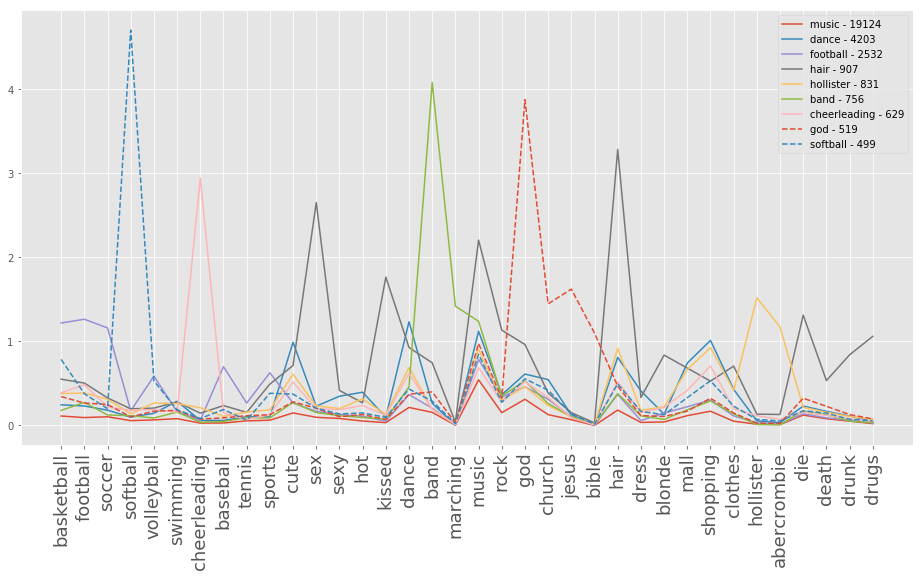

In [79]:
t0 = time.clock()
model = Kmeans(k=9, random_state=1234)
a = model.predict(df_sns.values)
print(time.clock() - t0)
process(a)

In [80]:
%%timeit 
model.predict(df_sns.values)

3.35 s ± 38.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cython + Numpy

0.5619597281815913


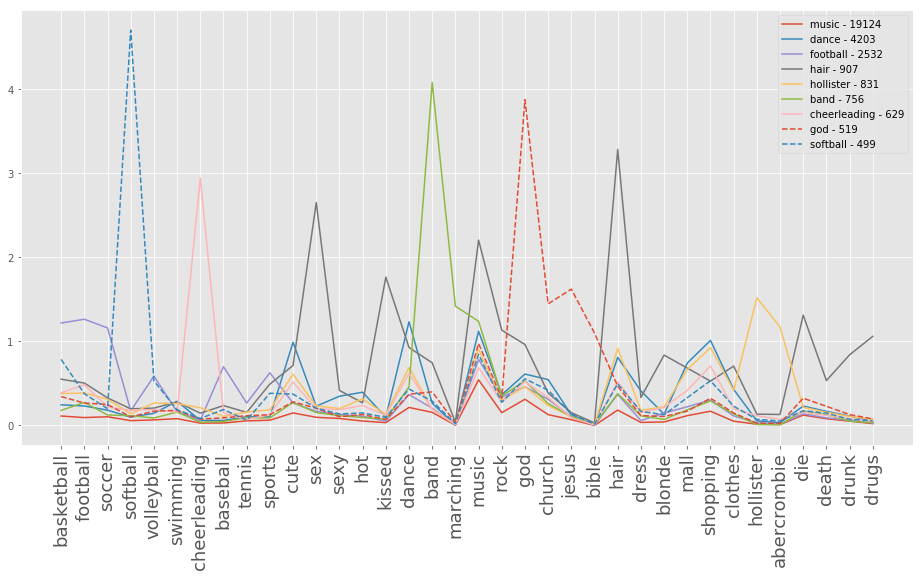

In [81]:
t0 = time.clock()
model = KmeansCythonNumpy(k_=9)
a = model.predict(df_sns.values)
print(time.clock() - t0)
process(a)

In [82]:
%%timeit 
model.predict(df_sns.values)

509 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cython 

0.521725835743382


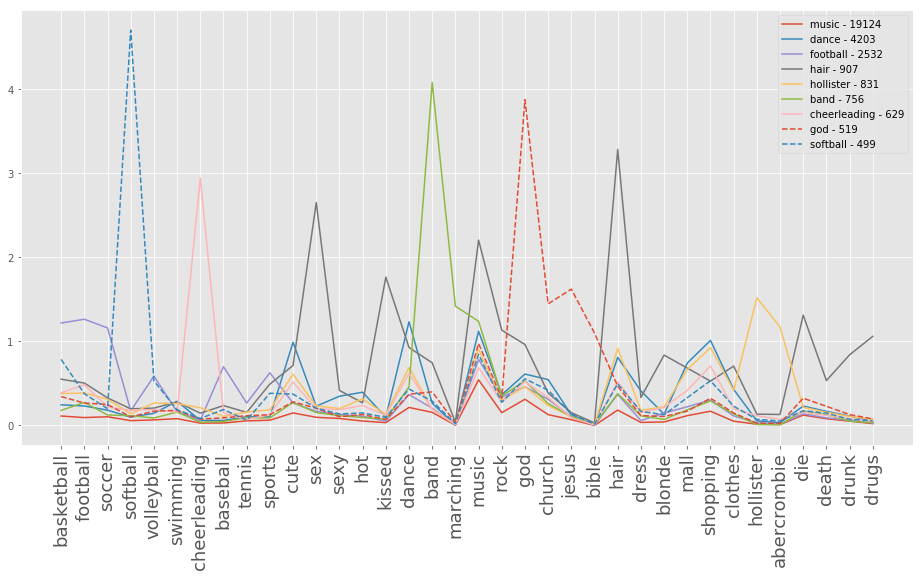

In [83]:
t0 = time.clock()
model = KmeansCython(k_=9)
a = model.predict(df_sns.values)
print(time.clock() - t0)
process(a)

In [84]:
%%timeit 
model.predict(df_sns.values)

514 ms ± 6.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Все, кроме выделения памяти и особенных питоновских методов np.random.choice и Exception были переведены в C, и реализация вышла в 7 раз быстрее numpy. Но некоторые вещи, например строчка с abs на numpy вышла быстрее, поэтому оптимальный код все-таки содержит и numpy из python, хоть на 90 процентов и был переведен в C.